In [1]:

from camel_dataloader import get_astro_data, Flip, Stack, get_astro_data_2D_from_3D,Normalize
from TF_utils import power_spectrum, getGrid
import numpy as np
from scipy.fft import fft2, ifft2, fftshift
import torch
from torch import Tensor
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
import time
import psutil
import Pk_library as PKL

ModuleNotFoundError: No module named 'camel_dataloader'

# Test dataloaders

In [14]:
import importlib
import camel_dataloader
importlib.reload(camel_dataloader) 
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D,Normalize

In [3]:
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
dm_25_thick = get_astro_data(
        dataset,
        thickness=25,
        num_workers=num_workers,
        # resize=cropsize,
        batch_size=batch_size,
        
    )

In [4]:
conditioning, params, target = next(iter(dm_25_thick.test_dataloader()))

In [5]:
conditioning.mean(),target.mean()

(tensor(-0.0740), tensor(-0.0728))

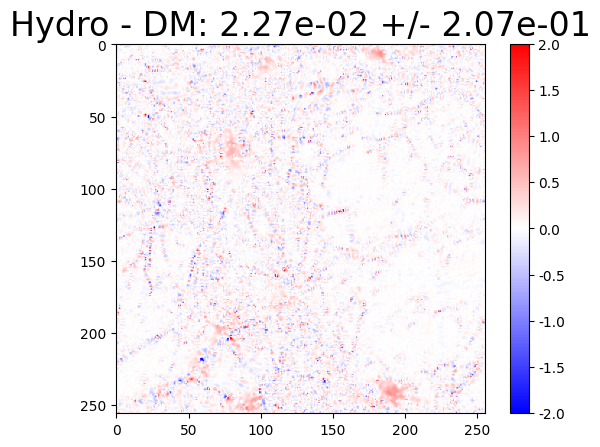

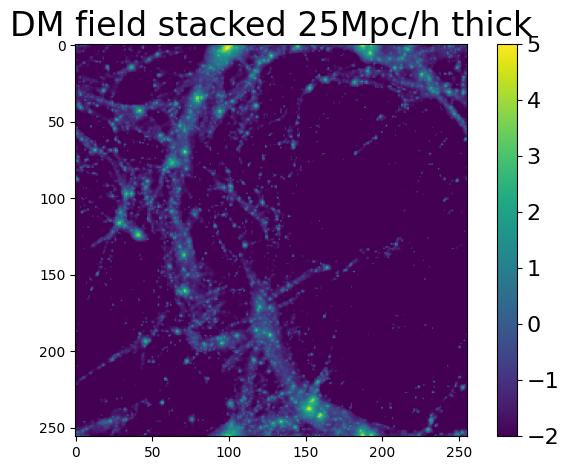

In [20]:
cond, x = Normalize(dataset).inverse_transform([conditioning,target])
x = x+cond
m_delta_log = torch.log(x[0]/x[0].mean()) - torch.log(cond[0]/cond[0].mean())
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('custom', colors)
vmin = -2.0
vmax = 2.0
plt.figure()
im = plt.imshow(m_delta_log.squeeze().cpu(),  cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
plt.title(f'Hydro - DM: {m_delta_log.mean():.2e} +/- {m_delta_log.std():.2e}', fontsize=24)
plt.show()

plt.figure()
plt.imshow((torch.log(cond[0]/cond[0].mean()).reshape([256,256])-1), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field stacked 25Mpc/h thick', fontsize=24)
plt.tight_layout()
plt.show()



In [17]:
cond.shape

torch.Size([50, 1, 256, 256])


Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


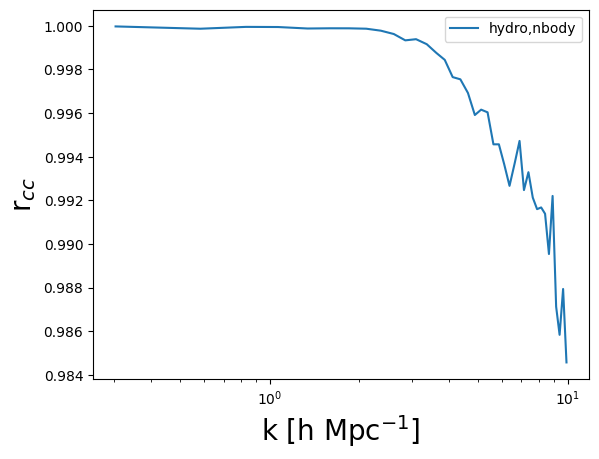


Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


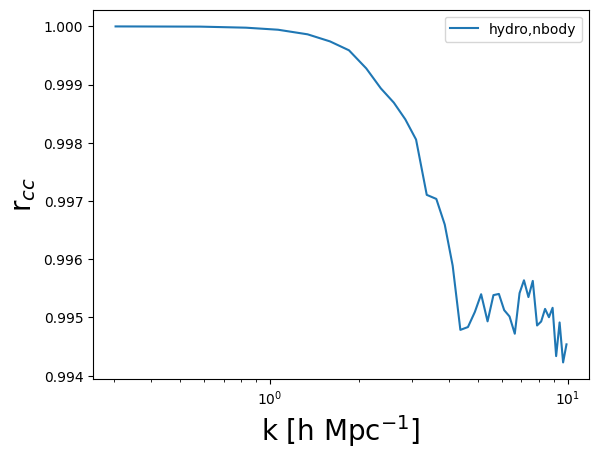

In [22]:
grid    = 256     #the map will have grid^2 pixels
BoxSize = 25 #Mpc/h
MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
threads = 1       #number of openmp threads
axis = 0
verbose = False

sims = [0,10]

for sim in sims:
    Pkcc = PKL.XPk_plane((x[sim]/x[sim].mean()-1).detach().numpy().reshape([256,256]),(cond[sim]/cond[sim].mean()-1).detach().numpy().reshape([256,256]),  BoxSize, MAS,MAS, threads=1) 
    kcc_true   = Pkcc.k
    Pk0_X_true = Pkcc.r
    
    plt.figure()
    plt.plot(kcc_true[kcc_true <= 10], Pk0_X_true[kcc_true <= 10],label = f'hydro,nbody')
    plt.xscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'r$_{cc}$', fontsize=20)
    plt.legend()
    plt.show()

In [35]:
_, NBody_grid, NBody_mean = getGrid('Astrid', 'LH', 256, '0.0', 'nbody', 30)
NBody_grid = np.array(NBody_grid, copy=True)+ 1.0
NBody_map = NBody_grid.mean(axis=0)

_, hydro_grid, hydro_mean = getGrid('Astrid', 'LH', 256, '0.0', 'hydro', 30)
hydro_grid = np.array(hydro_grid, copy=True)+ 1.0
hydro_map = hydro_grid.mean(axis=0)

In [3]:
print(np.all(NBody_grid>0))

True


# Test window function in fourier space

In [67]:
L = 25. #Mpc/c
H = 256
W = 256
fourier_upweight_range = [3,10]
low = fourier_upweight_range[0]
high = fourier_upweight_range[1]

kx = torch.fft.fftfreq(H, d=1. / (H * 2 * np.pi / L))
ky = torch.fft.fftfreq(W, d=1. / (W * 2 * np.pi / L))
kx, ky = torch.meshgrid(kx, ky, indexing="ij") #[256, 256],[256, 256]
k = torch.sqrt(kx**2 + ky**2) 

center = (low + high) / 2  # Center frequency
sigma = (high - low) / 2   # Standard deviation (controls the width of the Gaussian)

order = 2 
low_pass = 1 / (1 + (k / high)**(2 * order))
high_pass = 1 / (1 + (low / k)**(2 * order))

weight_mask =  torch.zeros_like(k)
weight_mask[(k >= fourier_upweight_range[0]) & (k <= fourier_upweight_range[1])] = 1

weight_mask_smooth = weight_mask * (0.5 * (1 - np.cos(2 * np.pi * (k - fourier_upweight_range[0]) / (fourier_upweight_range[1] - fourier_upweight_range[0]))))
weight_mask_gaussian = np.exp(-((k - center)**2) / (2 * sigma**2))
weight_mask_butterworth = low_pass*high_pass

/tmp/ipykernel_1064309/774908189.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  weight_mask_smooth = weight_mask * (0.5 * (1 - np.cos(2 * np.pi * (k - fourier_upweight_range[0]) / (fourier_upweight_range[1] - fourier_upweight_range[0]))))
/tmp/ipykernel_1064309/774908189.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  weight_mask_gaussian = np.exp(-((k - center)**2) / (2 * sigma**2))


/tmp/ipykernel_1064309/2487361344.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


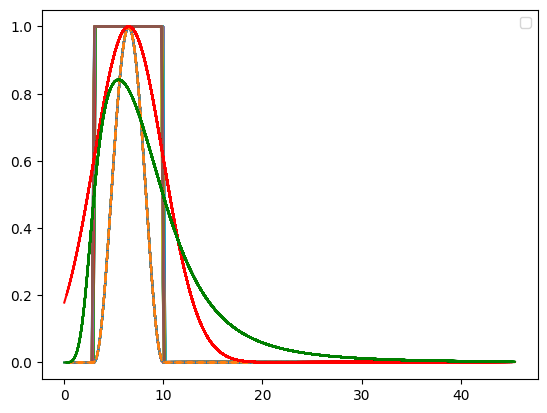

In [68]:
plt.plot(k,weight_mask,'-')
plt.plot(k,weight_mask_smooth, '--')
plt.plot(k,weight_mask_gaussian, 'r')
plt.plot(k,weight_mask_butterworth, 'g')
plt.legend()
plt.show()

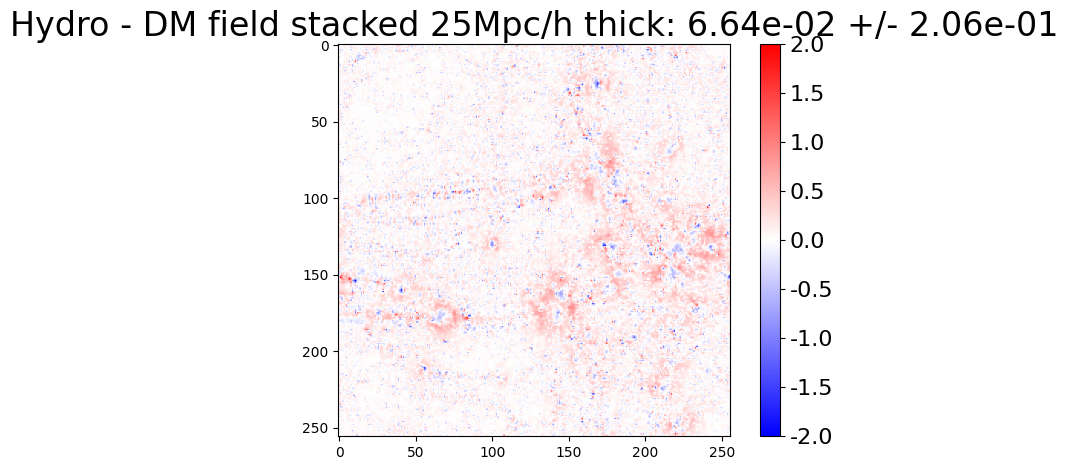

/tmp/ipykernel_1064309/2025427439.py:21: RuntimeWarning: invalid value encountered in log
  diff_trans = np.log(np.real(ifft2(fft2(hydro_map-NBody_map)*weight_mask_smooth.numpy()))+NBody_map) -  np.log(NBody_map)


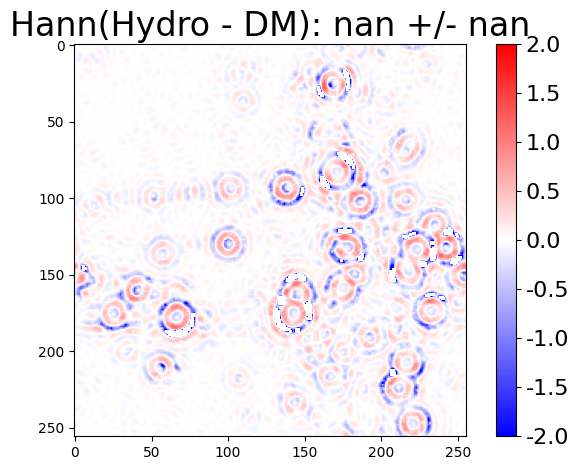

/tmp/ipykernel_1064309/2025427439.py:31: RuntimeWarning: invalid value encountered in log
  diff_trans = np.log(np.real(ifft2(fft2(hydro_map-NBody_map)*weight_mask.numpy()))+NBody_map) -  np.log(NBody_map)
/tmp/ipykernel_1064309/2025427439.py:32: RuntimeWarning: invalid value encountered in log
  im = plt.imshow(np.log(diff_trans+NBody_map) -  np.log(NBody_map), cmap=cmap, vmin=vmin, vmax=vmax)


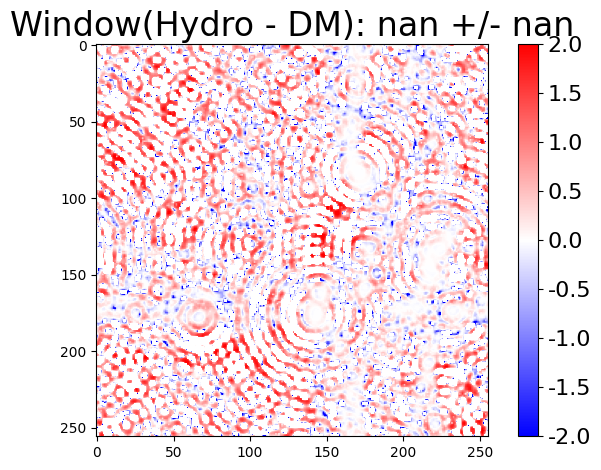

/tmp/ipykernel_1064309/2025427439.py:40: RuntimeWarning: invalid value encountered in log
  diff_trans = np.log(np.real(ifft2(fft2(hydro_map-NBody_map)*weight_mask_gaussian.numpy()))+NBody_map) -  np.log(NBody_map)
/tmp/ipykernel_1064309/2025427439.py:41: RuntimeWarning: invalid value encountered in log
  im = plt.imshow(np.log(diff_trans+NBody_map) -  np.log(NBody_map), cmap=cmap, vmin=vmin, vmax=vmax)


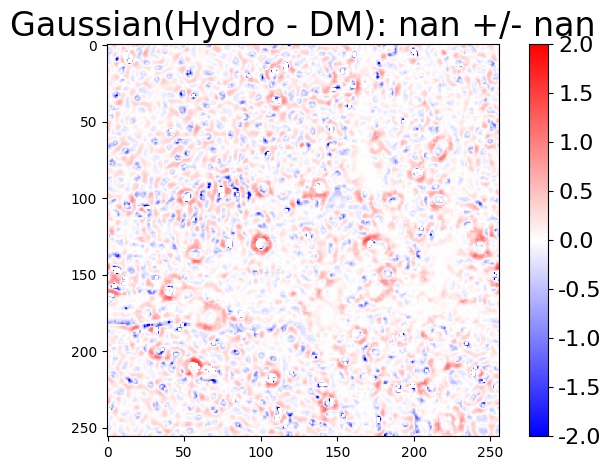

/tmp/ipykernel_1064309/2025427439.py:49: RuntimeWarning: invalid value encountered in log
  diff_trans = np.log(np.real(ifft2(fft2(hydro_map-NBody_map)*weight_mask_butterworth.numpy()))+NBody_map) -  np.log(NBody_map)
/tmp/ipykernel_1064309/2025427439.py:50: RuntimeWarning: invalid value encountered in log
  im = plt.imshow(np.log(diff_trans+NBody_map) -  np.log(NBody_map), cmap=cmap, vmin=vmin, vmax=vmax)


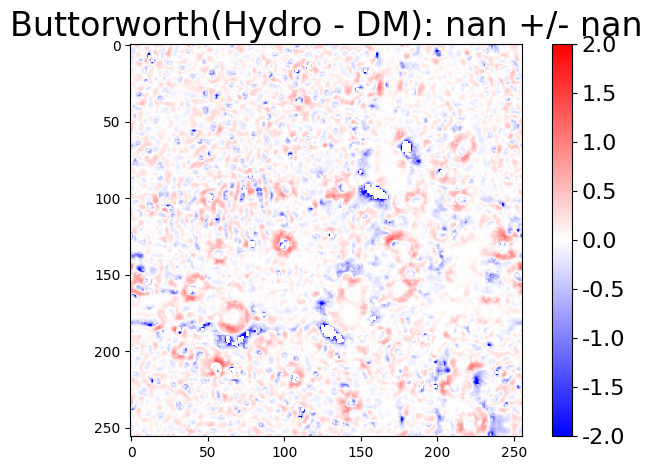

In [69]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('custom', colors)

vmin = -2.0
vmax = 2.0

diff = np.log(hydro_map) - np.log(NBody_map)
plt.figure()
im = plt.imshow(diff, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title(f'Hydro - DM field stacked 25Mpc/h thick: {diff.mean():.2e} +/- {diff.std():.2e}', fontsize=24)
plt.tight_layout()
plt.show()


plt.figure()
diff_trans = np.log(np.real(ifft2(fft2(hydro_map-NBody_map)*weight_mask_smooth.numpy()))+NBody_map) -  np.log(NBody_map)
im = plt.imshow(diff_trans, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title(f'Hann(Hydro - DM): {diff_trans.mean():.2e} +/- {diff_trans.std():.2e}', fontsize=24)
plt.tight_layout()
plt.show()


plt.figure()
diff_trans = np.log(np.real(ifft2(fft2(hydro_map-NBody_map)*weight_mask.numpy()))+NBody_map) -  np.log(NBody_map)
im = plt.imshow(np.log(diff_trans+NBody_map) -  np.log(NBody_map), cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title(f'Window(Hydro - DM): {diff_trans.mean():.2e} +/- {diff_trans.std():.2e}', fontsize=24)
plt.tight_layout()
plt.show()

plt.figure()
diff_trans = np.log(np.real(ifft2(fft2(hydro_map-NBody_map)*weight_mask_gaussian.numpy()))+NBody_map) -  np.log(NBody_map)
im = plt.imshow(np.log(diff_trans+NBody_map) -  np.log(NBody_map), cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title(f'Gaussian(Hydro - DM): {diff_trans.mean():.2e} +/- {diff_trans.std():.2e}', fontsize=24)
plt.tight_layout()
plt.show()

plt.figure()
diff_trans = np.log(np.real(ifft2(fft2(hydro_map-NBody_map)*weight_mask_butterworth.numpy()))+NBody_map) -  np.log(NBody_map)
im = plt.imshow(np.log(diff_trans+NBody_map) -  np.log(NBody_map), cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title(f'Buttorworth(Hydro - DM): {diff_trans.mean():.2e} +/- {diff_trans.std():.2e}', fontsize=24)
plt.tight_layout()
plt.show()

# Stack for 25 Mpc thickness

Execution time for one sim: 0.0494 seconds


/tmp/ipykernel_1527102/1084170090.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(Nbody_map.squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)


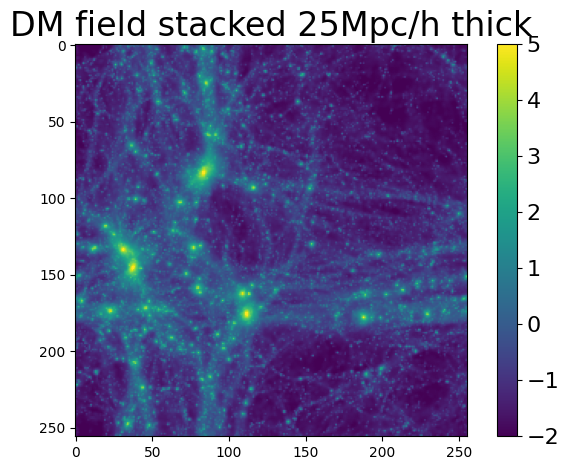

In [4]:
import time
start_time = time.time()
Nbody_map = Flip(2)(Tensor(NBody_map))
end_time = time.time()
# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time for one sim: {execution_time:.4f} seconds")

plt.figure()
plt.imshow(np.log(Nbody_map.squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field stacked 25Mpc/h thick', fontsize=24)
plt.tight_layout()
plt.show()

In [5]:
print(Tensor(np.asarray(NBody_grid)).unsqueeze(0).shape)

torch.Size([1, 256, 256, 256])


In [2]:
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4

cpu_before = psutil.cpu_percent(interval=None)
    
    # Start time measurement
start_time = time.time()
    
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size,
        map_per_sim=3)
    
    # Record final CPU usage
cpu_after = psutil.cpu_percent(interval=None)
elapsed_time = time.time() - start_time
    
print(f"CPU usage before execution: {cpu_before}%")
print(f"CPU usage after execution: {cpu_after}%")
print(f"Function execution time: {elapsed_time:.2f} seconds")

CPU usage before execution: 0.2%
CPU usage after execution: 1.7%
Function execution time: 149.68 seconds


In [ ]:
one_batch = next(iter(dm_TF.test_dataloader()))
conditioning, params, target = one_batch
print(conditioning.shape, params.shape,target.shape)
print(conditioning.device, params.device,target.device)

In [ ]:
start_time = time.time()

train_dir = '/pscratch/sd/l/lindajin/CAMELS/'
map_per_sim = 3
mass_mtot = np.load(train_dir+
                    f'Grids_Mtot_Astrid_LH_256_z=0.0.npy'
                )        
mass_cdm = np.load(train_dir+
                    f'Grids_Mcdm_Astrid_LH_256_z=0.0.npy'
                )
params = np.loadtxt(train_dir+
                    f'params_LH_Astrid.txt'
                )

maps_params = np.empty((map_per_sim*len(mass_mtot),params.shape[1]))
mass_mtot_2D = Tensor(np.concatenate((mass_mtot.mean(axis = 1),mass_mtot.mean(axis = 2),mass_mtot.mean(axis = 3)),axis=0)).unsqueeze(1)
mass_cdm_2D = Tensor(np.concatenate((mass_cdm.mean(axis = 1),mass_cdm.mean(axis = 2),mass_cdm.mean(axis = 3)), axis=0)).unsqueeze(1)
for i in range(len(mass_mtot)):
    maps_params[i]= params[i//map_per_sim]

maps_params = Tensor(np.asarray(maps_params))

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time for one sim: {execution_time:.4f} seconds")

# Stack for 100 Mpc thickness

Execution time for one sim: 0.1289 seconds


/tmp/ipykernel_1978659/1885226446.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(Nbody_map[0].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)


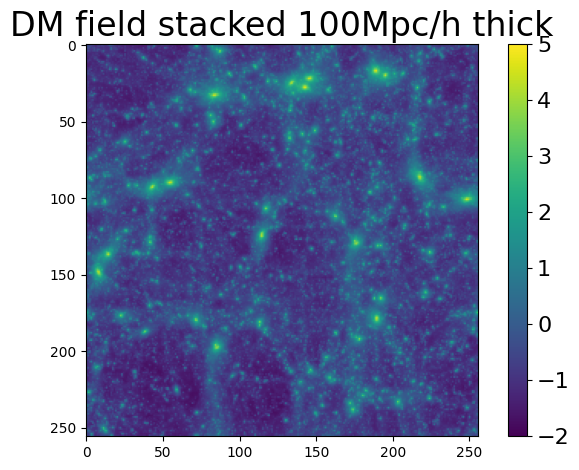

/tmp/ipykernel_1978659/1885226446.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(Nbody_map[2].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)


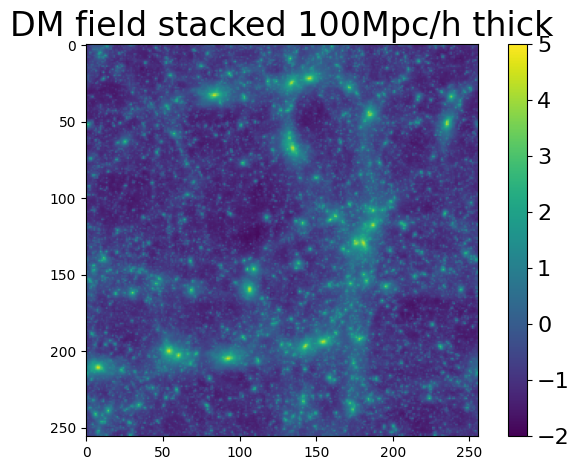

/tmp/ipykernel_1978659/1885226446.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(Nbody_map[3].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)


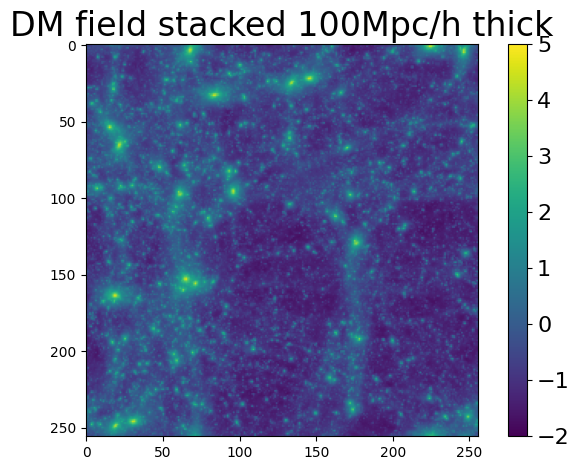

/tmp/ipykernel_1978659/1885226446.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(Nbody_map[4].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)


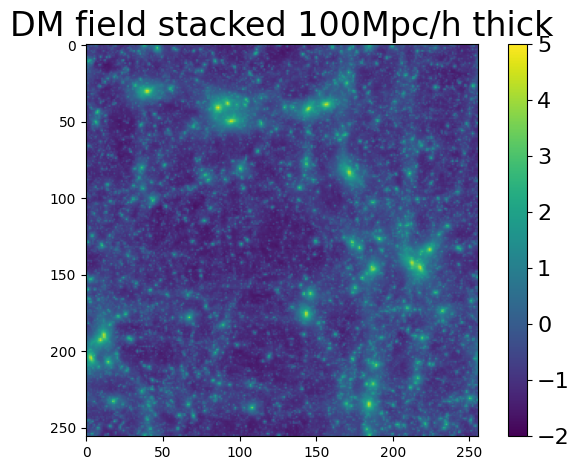

In [6]:
start_time = time.time()
Nbody_map = Stack(5)(Tensor(np.asarray(NBody_grid)).unsqueeze(0))
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time for one sim: {execution_time:.4f} seconds")

plt.figure()
plt.imshow(np.log(Nbody_map[0].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field stacked 100Mpc/h thick', fontsize=24)
plt.tight_layout()
plt.show()
plt.figure()
plt.imshow(np.log(Nbody_map[2].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field stacked 100Mpc/h thick', fontsize=24)
plt.tight_layout()
plt.show()
plt.figure()
plt.imshow(np.log(Nbody_map[3].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field stacked 100Mpc/h thick', fontsize=24)
plt.tight_layout()
plt.show()
plt.figure()
plt.imshow(np.log(Nbody_map[4].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field stacked 100Mpc/h thick', fontsize=24)
plt.tight_layout()
plt.show()

In [32]:
print(np.all(NBody_grid > 0))
for m in Nbody_map:
    print(torch.std(m))

True
tensor(2.3545)
tensor(2.3600)
tensor(2.3372)
tensor(2.3666)
tensor(2.3995)


In [3]:
import importlib
import camel_dataloader

importlib.reload(camel_dataloader) 
from camel_dataloader import Stack, Flip, get_astro_data_2D_from_3D

In [57]:
mass_cdm = Tensor(np.asarray([NBody_grid,NBody_grid])).unsqueeze(1) #torch.Size([1, 1, 256, 256, 256])
mass_cdm_2D = [] #torch.Size([1*5, 1, 256, 256, 256])
for i, img in enumerate(mass_cdm):
    print(img.shape)
    maps = Stack(5)(img)
    print(maps.shape)
    mass_cdm_2D.append(maps)
    
mass_cdm_2D = torch.cat(mass_cdm_2D, dim=0) 
print(mass_cdm_2D.shape)

torch.Size([1, 256, 256, 256])
for flip torch.Size([256, 256])
for rotate torch.Size([256, 256])
for flip torch.Size([256, 256])
for flip torch.Size([256, 256])
for rotate torch.Size([256, 256])
for rotate torch.Size([256, 256])
torch.Size([5, 1, 256, 256])
torch.Size([1, 256, 256, 256])
for rotate torch.Size([256, 256])
for flip torch.Size([256, 256])
for flip torch.Size([256, 256])
for flip torch.Size([256, 256])
for rotate torch.Size([256, 256])
for flip torch.Size([256, 256])
for flip torch.Size([256, 256])
for rotate torch.Size([256, 256])
torch.Size([5, 1, 256, 256])
torch.Size([10, 1, 256, 256])


In [12]:

start_time = time.time()

train_dir = '/pscratch/sd/l/lindajin/CAMELS/'
map_per_sim = 15
mass_mtot = np.load(train_dir+
                    f'Grids_Mtot_Astrid_LH_256_z=0.0.npy'
                )        
mass_cdm = np.load(train_dir+
                    f'Grids_Mcdm_Astrid_LH_256_z=0.0.npy'
                )
params = np.loadtxt(train_dir+
                    f'params_LH_Astrid.txt'
                )

maps_params = np.empty((map_per_sim*len(mass_mtot),params.shape[1]))
mass_mtot_2D = []
mass_cdm_2D = [] #torch.Size([1*5, 1, 256, 256, 256])
for i in range(len(mass_mtot)):
    maps_params[i]= params[i//map_per_sim]
    mass_mtot_2D.append(Stack(map_per_sim)(Tensor(mass_mtot).unsqueeze(1)[i]))
    mass_cdm_2D.append(Stack(map_per_sim)(Tensor(mass_cdm).unsqueeze(1)[i]))

maps_params = Tensor(np.asarray(maps_params))
mass_cdm_2D = torch.cat(mass_cdm_2D, dim=0) 
mass_mtot_2D = torch.cat(mass_mtot_2D, dim=0) 

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time for one sim: {execution_time:.4f} seconds")

Execution time for one sim: 221.4316 seconds


In [13]:
print(mass_mtot_2D.shape, mass_cdm_2D.shape, maps_params.shape)
# Convert PyTorch tensors to NumPy arrays
maps_params_np = maps_params.cpu().numpy()  # Ensure tensor is on the CPU before conversion
mass_cdm_2D_np = mass_cdm_2D.cpu().numpy()
mass_mtot_2D_np = mass_mtot_2D.cpu().numpy()

np.save(train_dir+f"Maps_{map_per_sim}_params_LH_Astrid.npy", maps_params_np)
np.save(train_dir+f"Maps_{map_per_sim}_thick=100_Mcdm_Astrid_LH_256_z=0.0.npy", mass_cdm_2D_np)
np.save(train_dir+f"Maps_{map_per_sim}_thick=100_Mtot_Astrid_LH_256_z=0.0.npy", mass_mtot_2D_np)

print("Files saved successfully!")

torch.Size([15000, 1, 256, 256]) torch.Size([15000, 1, 256, 256]) torch.Size([15000, 6])
Files saved successfully!


In [16]:
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4

cpu_before = psutil.cpu_percent(interval=None)
    
    # Start time measurement
start_time = time.time()
    
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size)
    
    # Record final CPU usage
cpu_after = psutil.cpu_percent(interval=None)
elapsed_time = time.time() - start_time
    
print(f"CPU usage before execution: {cpu_before}%")
print(f"CPU usage after execution: {cpu_after}%")
print(f"Function execution time: {elapsed_time:.2f} seconds")

CPU usage before execution: 3.6%
CPU usage after execution: 10.8%
Function execution time: 170.44 seconds


In [ ]:
one_batch = next(iter(dm_TF.test_dataloader()))
conditioning, params, target = one_batch
print(conditioning.shape, params.shape,target.shape)
print(conditioning.device, params.device,target.device)